##### 1. 使用 5-fold Cross-Validation 選取能達到最高 CV 正確率的 k。此最佳 k的 CV 正確率為多少？

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x_train = pd.read_csv('x_train.csv')
print(x_train.shape)
y_train = pd.read_csv('y_train.csv', header=None)
print(y_train.shape)
x_test = pd.read_csv('x_test.csv')
print(x_test.shape)
y_test = pd.read_csv('y_test.csv', header=None)
print(y_test.shape)


(361, 16384)
(361, 1)
(42, 16384)
(42, 1)


In [125]:
x_test = x_test.to_numpy()
x_train = x_train.to_numpy()
# 把它變成一維
y_test = y_test.to_numpy().astype(int).ravel() 
y_train = y_train.to_numpy().astype(int).ravel() 

print("\n--------------new------------\n")
print("x_train:",x_train.shape)
print("y_train:",y_train.shape)
print("x_test:",x_test.shape)
print("y_test:",y_test.shape)



--------------new------------

x_train: (361, 16384)
y_train: (361,)
x_test: (42, 16384)
y_test: (42,)


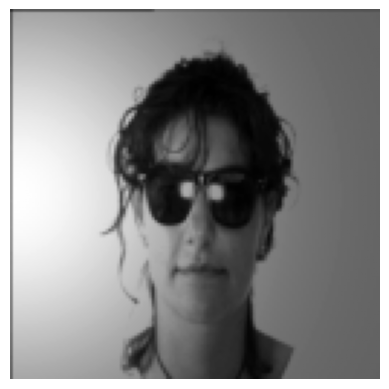

1


In [126]:
# 會發現多一個因為是欄位名裡面是 0 1 2 3 4 5 6 
# 所以要用掉
import matplotlib.pyplot as plt
import numpy as np
image = x_train[100,:].reshape(128,128)
plt.imshow(image , cmap='gray')
plt.axis('off')
plt.show()
print(y_train[100])


- 先試試看k=3的

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import numpy as np



# ===== Model =====
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)

# ===== Predict =====
y_pred = knn.predict(x_test)

# ===== Evaluate =====
# print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5609756097560976


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")


- 這邊只是看看是否一樣但這樣按理來說一定一樣因為我是用train的部分
- 所以也會一樣

In [53]:
x = x_train[0].reshape(1, -1)
y_pred = knn.predict(x)
print(y_pred)
print(y_train[0])

[1]
1


- 但是假如用test就不一定了

In [54]:
x = x_test[0].reshape(1, -1)
y_pred = knn.predict(x)
print(y_pred)
print(y_test[0])

[5]
13


In [55]:
# 假設你的 x_train 是 DataFrame 或 Numpy array
import pandas as pd

# 如果是 numpy array，先轉成 DataFrame 比較好檢查
df_check = pd.DataFrame(x_train)
duplicates = df_check.duplicated().sum()

print(f"重複的樣本數: {duplicates}")

重複的樣本數: 0


- 接下來使用5-fold Cross-Validation

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler #標準化
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler #除以255

k_values = list(range(1, 21, 2))

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

mean_accuracies = []

for k in k_values:
    pipe = Pipeline([
        # ("scaler", MinMaxScaler()), 
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

    scores = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean():.3f}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.853
k= 3, Accuracy=0.719
k= 5, Accuracy=0.669
k= 7, Accuracy=0.564
k= 9, Accuracy=0.522
k=11, Accuracy=0.472
k=13, Accuracy=0.442
k=15, Accuracy=0.400
k=17, Accuracy=0.386
k=19, Accuracy=0.369
Best k = 1


- 感覺上面的是有問題的，是因為在這麼高維度的空間中分很開嗎，所以1就不錯了

- 因為原本權重一樣的所以我想要試試看 權重根據距離

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler #標準化
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler #除以255

k_values = list(range(1, 21, 2))

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

mean_accuracies = []

for k in k_values:
    pipe = Pipeline([
        # ("scaler", MinMaxScaler()), 
        ("knn", KNeighborsClassifier(n_neighbors=k , weights='distance'))
    ])

    scores = cross_val_score(
        pipe,
        x_train,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean():.3f}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.853
k= 3, Accuracy=0.794
k= 5, Accuracy=0.761
k= 7, Accuracy=0.681
k= 9, Accuracy=0.661
k=11, Accuracy=0.625
k=13, Accuracy=0.600
k=15, Accuracy=0.567
k=17, Accuracy=0.558
k=19, Accuracy=0.550
Best k = 1


- 這樣看起來確實有比較好一點

- 想要看看不同seed的效果

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

k_values = list(range(1, 21, 2))
random_seeds = [0, 1, 2, 42, 123]

rows = []

for k in k_values:
    seed_scores = []

    for seed in random_seeds:
        cv = StratifiedKFold(
            n_splits=5,
            shuffle=True,
            random_state=seed
        )

        pipe = Pipeline([
            ("knn", KNeighborsClassifier(n_neighbors=k))
        ])

        scores = cross_val_score(
            pipe,
            x_train,
            y_train,
            cv=cv,
            scoring="accuracy"
        )

        seed_scores.append(scores.mean())

    rows.append({
        "k": k,
        "mean_accuracy": np.mean(seed_scores),
        "std_accuracy": np.std(seed_scores)
    })

df_results = pd.DataFrame(rows)
df_results


,k,mean_accuracy,std_accuracy
0,1,0.870000,0.013076
1,3,0.736111,0.009296
2,5,0.681667,0.007158
3,7,0.582778,0.015556
4,9,0.531111,0.013076
5,11,0.478333,0.003685
6,13,0.455000,0.010599
7,15,0.422222,0.015113
8,17,0.397778,0.011027
9,19,0.377778,0.007027


In [59]:
rows = []

for k in k_values:
    for seed in random_seeds:
        cv = StratifiedKFold(
            n_splits=5,
            shuffle=True,
            random_state=seed
        )

        pipe = Pipeline([
            ("scaler", MinMaxScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k))
        ])

        scores = cross_val_score(
            pipe,
            x_train,
            y_train,
            cv=cv,
            scoring="accuracy"
        )

        rows.append({
            "k": k,
            "random_seed": seed,
            "accuracy": scores.mean()
        })

df_long = pd.DataFrame(rows)
df_long


,k,random_seed,accuracy
0,1,0,0.872222
1,1,1,0.872222
2,1,2,0.861111
3,1,42,0.852778
4,1,123,0.891667
5,3,0,0.747222
6,3,1,0.736111
7,3,2,0.736111
8,3,42,0.719444
9,3,123,0.741667


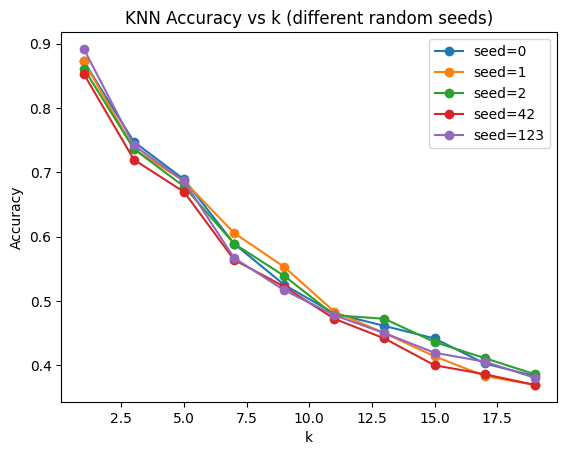

In [15]:
import matplotlib.pyplot as plt

plt.figure()

for seed in sorted(df_long["random_seed"].unique()):
    sub = df_long[df_long["random_seed"] == seed]
    plt.plot(
        sub["k"],
        sub["accuracy"],
        marker="o",
        label=f"seed={seed}"
    )

plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy vs k (different random seeds)")
plt.legend()
plt.show()


##### 使用 1. 中選出的最佳 k，對所有測試影像進行分類。其在測試資料上的判別正確率為多少？

In [122]:

# 1. 使用剛剛選出來的最佳 k (best_k) 重新建立模型 pipeline
final_pipe = Pipeline([
    # ("scaler", MinMaxScaler()), 
    ("knn", KNeighborsClassifier(n_neighbors=1)) 
])

final_pipe.fit(x_train, y_train)


test_score = final_pipe.score(x_test, y_test)

print("-" * 30)
print(f"最佳 k 值: {best_k}")
print(f"測試集 (Test Set) 準確率: {test_score:.3f}")

------------------------------
最佳 k 值: 1
測試集 (Test Set) 準確率: 0.780


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")


##### Part II 使用 KNN 配合特徵擷取做臉部影像辨識

-  使用 PCA 做特徵擷取

- 這邊只是資料處理

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

x_train = pd.read_csv('x_train.csv')
print(x_train.shape)
y_train = pd.read_csv('y_train.csv')
print(y_train.shape)
x_test = pd.read_csv('x_test.csv')
print(x_test.shape)
y_test = pd.read_csv('y_test.csv')
print(y_test.shape)
x_train = x_train.iloc[1:,:].astype(float)
x_test = x_test.iloc[1: , :].astype(float)
x_test = x_test.to_numpy()
x_train = x_train.to_numpy()
# 把它變成一維
y_test = y_test.to_numpy().astype(int).ravel() 
y_train = y_train.to_numpy().astype(int).ravel() 

(361, 16384)
(360, 1)
(42, 16384)
(41, 1)


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# 1. 資料標準化 

scaler = StandardScaler()


x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 2. 執行 PCA
pca = PCA(n_components=0.95) 


x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

#這邊是我不太確定分別對他做pca會不會投到不同的空間中
mu = pca.mean_          # shape: (original_dim,)
W = pca.components_.T  # shape: (original_dim, pca_dim)
x_test_pca_manual = (x_test_scaled - mu) @ W
x_test_pca_sklearn = pca.transform(x_test_scaled)
print(np.allclose(x_test_pca_manual, x_test_pca_sklearn))
print(np.max(np.abs(x_test_pca_manual - x_test_pca_sklearn)))

x_test_pca = x_test_pca_manual
print("原始維度:", x_train.shape[1])
print("降維後維度:", x_train_pca.shape[1])
print("總共解釋的變異量:", np.sum(pca.explained_variance_ratio_))

True
1.1368683772161603e-13
原始維度: 16384
降維後維度: 52
總共解釋的變異量: 0.9500808156863664


- 拿一張出來前後對比

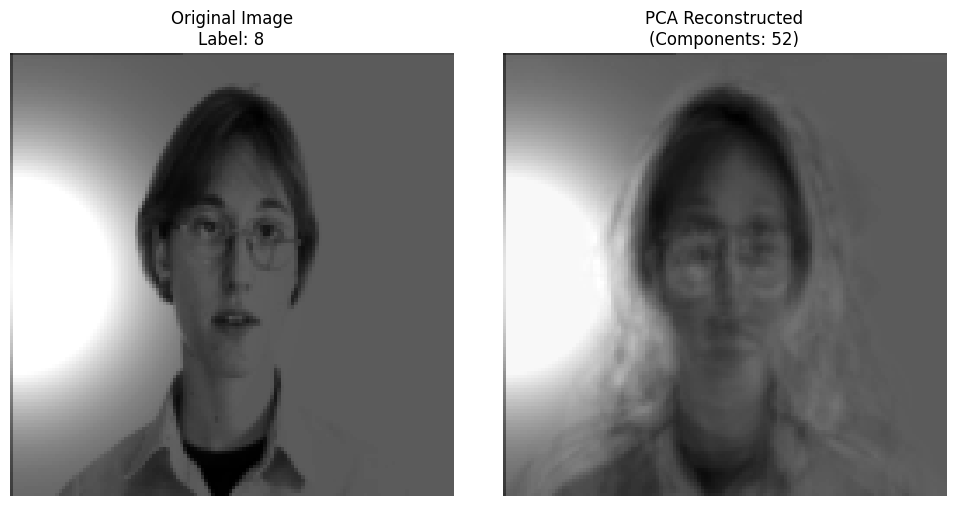

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)


pca = PCA(n_components=0.95) 
x_train_pca = pca.fit_transform(x_train_scaled)



x_projected = pca.inverse_transform(x_train_pca)

x_reconstructed = scaler.inverse_transform(x_projected)


idx = 10 

plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)

original_img = x_train[idx].reshape(128, 128) 
plt.imshow(original_img, cmap='gray')
plt.title(f'Original Image\nLabel: {y_train[idx]}')
plt.axis('off')


plt.subplot(1, 2, 2)
reconstructed_img = x_reconstructed[idx].reshape(128, 128)
plt.imshow(reconstructed_img, cmap='gray')
plt.title(f'PCA Reconstructed\n(Components: {pca.n_components_})')
plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_values = list(range(1, 21, 2))
mean_accuracies = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(n_neighbors=k))
    ])

    scores = cross_val_score(
        pipe,
        x_train_pca,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean():.3f}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=0.839
k= 3, Accuracy=0.789
k= 5, Accuracy=0.742
k= 7, Accuracy=0.703
k= 9, Accuracy=0.686
k=11, Accuracy=0.661
k=13, Accuracy=0.669
k=15, Accuracy=0.639
k=17, Accuracy=0.625
k=19, Accuracy=0.611
Best k = 1


In [101]:
# 1. 建立最終的 Pipeline 模型 (使用最佳 k)
final_pipe = Pipeline([ 
    ("knn", KNeighborsClassifier(
        n_neighbors=1,
    ))
])

# 2. 使用「所有」訓練資料進行擬合 (Fit)
final_pipe.fit(x_train_pca, y_train)

# 3. 對測試資料 (Test Data) 進行預測並計算準確率
y_pred = final_pipe.predict(x_test_pca)
test_accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"測試集 (Test Set) 辨識正確率: {test_accuracy}")

------------------------------
測試集 (Test Set) 辨識正確率: 0.6829268292682927


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")


<hr>
<hr>

- 這邊試試看LDA

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()

x_train_lda = lda.fit_transform(x_train, y_train)# 這邊已經算出線性組合
x_test_lda = lda.transform(x_test)#會套用這邊的

print("原始維度:", x_train.shape[1])
print("LDA 後維度:", x_train_lda.shape[1])

best_k = 1
# 做knn 
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k, # 這邊k = 1 用cross validation得出的
    ))
])


final_pipe.fit(x_train_lda, y_train)


y_pred = final_pipe.predict(x_test_lda)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"測試集辨識正確率: {test_accuracy}")


原始維度: 16384
LDA 後維度: 20
------------------------------
測試集 (Test Set) 辨識正確率: 0.6341463414634146


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")


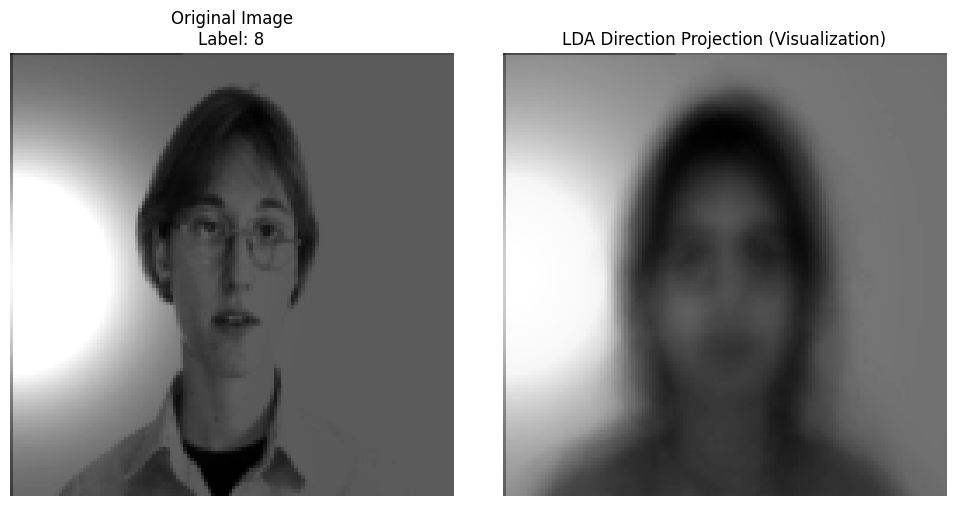

In [116]:
idx = 10
original_img = x_train[idx].reshape(128, 128)


# LDA 投影矩陣
W = lda.scalings_[:, :x_train_lda.shape[1]]  # (原始維度, lda_dim)

# 取該樣本的 LDA 座標
z = x_train_lda[idx]  # (lda_dim,)

# 投影回原空間（近似）
x_lda_back = z @ W.T  # (原始維度,)
x_lda_back = scaler.inverse_transform(x_lda_back.reshape(1, -1))



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img, cmap="gray")
plt.title(f"Original Image\nLabel: {y_train[idx]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(x_lda_back.reshape(128, 128), cmap="gray")
plt.title("LDA Direction Projection (Visualization)")
plt.axis("off")

plt.tight_layout()
plt.show()


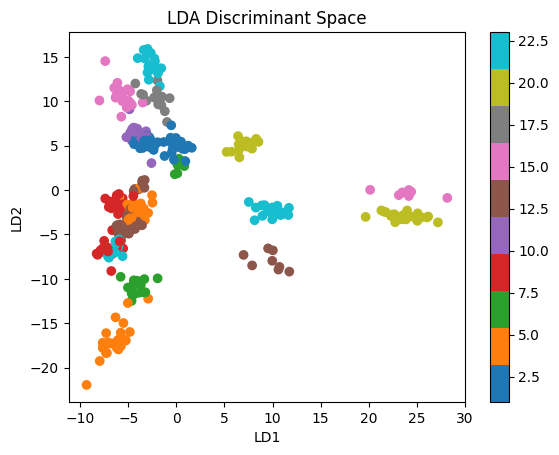

In [117]:
plt.scatter(x_train_lda[:, 0], x_train_lda[:, 1], c=y_train, cmap="tab10")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.title("LDA Discriminant Space")
plt.colorbar()
plt.show()


In [118]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

k_values = list(range(1, 21, 2))
mean_accuracies = []

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=20
)

for k in k_values:
    pipe = Pipeline([
        ("knn", KNeighborsClassifier(
            n_neighbors=k
        ))
    ])

    scores = cross_val_score(
        pipe,
        x_train_lda,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    mean_accuracies.append(scores.mean())
    print(f"k={k:2d}, Accuracy={scores.mean()}")

best_k = k_values[np.argmax(mean_accuracies)]
print("Best k =", best_k)


k= 1, Accuracy=1.0
k= 3, Accuracy=1.0
k= 5, Accuracy=1.0
k= 7, Accuracy=1.0
k= 9, Accuracy=1.0
k=11, Accuracy=1.0
k=13, Accuracy=0.9833333333333334
k=15, Accuracy=0.975
k=17, Accuracy=0.9638888888888889
k=19, Accuracy=0.9388888888888889
Best k = 1


In [ ]:
# 做knn 這邊k = 1
final_pipe = Pipeline([
    ("knn", KNeighborsClassifier(
        n_neighbors=best_k,
    ))
])


final_pipe.fit(x_train_lda, y_train)


y_pred = final_pipe.predict(x_test_lda)
test_accuracy = accuracy_score(y_test, y_pred)

print("-" * 30)
print(f"測試集 (Test Set) 辨識正確率: {test_accuracy}")



------------------------------
測試集 (Test Set) 辨識正確率: 0.6341463414634146


/Users/papaya/.venvs/py312-arm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")


- 這上面感覺應該試overfitting 了

###### 結論：
- 其實在原始資料下準確度反而是最高的
- 反而在pca lda降維度後反而正確度下降了
- 」、、